#  Прогнозирование заказов такси

**Описание проекта**<br>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Задачи, которые необходимо решить:
1. Разработать модель, которая сможет предсказать количество заказов в следующий час.
2. Показатель RMSE на тестовой выборке должен быть не более 48.
  
**Заказчику важны:**<br>
- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта**<br>

- загрузить данные;
- изучить представленные данные;
- выполнить ресемплирование данных по часу;
- проанализировать данные на тренды, сезонность и шумы;
- подготовить данные для обучения;
- обучить несколько моделей и подобрать оптимальные гиперпараметры;
- проверить модели на валидационных выборках с выводом RSME;
- выбрать лучшую модель и проверить ее качество на тестовой выборке.

**Входные данные**<br>
- Файл "taxi.csv" - данные о заказах такси в аэропорту.

**Описание данных**<br>
*datetime* - дата и время
*num_orders* — количество заказов такси<br>

**Методология и инструменты**<br>

*Методы:*<br>
- Сбор данных: 1 таблица, полученная от заказчика: "taxi.csv".<br>
- Ресемплирование данных: данные будут ресемплированы по часу.<br>
- Анализ данных: на тренды, сезонность и шумы.<br>
- Обучение моделей: несколько на выбор с оптимизацией гиперпараметров. <br>
- Проверка качества работы модели. <br>

*Инструменты:*<br>

- Python: Основной язык программирования для анализа данных.<br>
- Pandas: Библиотека для обработки и анализа данных.<br>
- Matplotlib и Seaborn: Библиотеки для визуализации данных.<br>
- sklearn: Библиотека для машинного обучения.<br>

*Дополнительные методы и инструменты:*<br>
- Jupyter Notebook: Для интерактивного анализа данных, создания отчетов, обучение и проверка моделей.

In [1]:
# подключение библиотек
import re
import warnings
from warnings import simplefilter

!pip install catboost
!pip install scikit-learn==1.1.0 -q
!pip install matplotlib==3.5.1 -q
!pip install -U statsmodels

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

from time import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Подготовка констант:
RANDOM_STATE = 42
TEST_SIZE = 0.1

pd.DataFrame.iteritems = pd.DataFrame.items

In [4]:
# цвета для графиков:
colors = (['#063751','#08527A',
           '#0B6DA2','#0E89CB',
           '#15A3EF','#3EB3F2',
           '#66C3F4','#8FD3F7',
           '#B7E3FA','#B7E3FA',
           '#8FD3F7','#66C3F4',
           '#3EB3F2','#15A3EF',
           '#0E89CB','#0B6DA2',
           '#08527A','#063751'])

In [5]:
# Функция data_info отображает основную информацию об имеющихся данных из указанного файла
def data_info(data):
    try:
        display('Общая информация')
        data.info()
        display('Первые пять строк данных:')
        display(data.head())
        display('Последние пять строк данных:')
        display(data.tail())
        display('Описание данных:')
        display(data.describe())
        display('Количество пропусков')
        display(data.isna().sum())
    except:
        return 'Проверьте параметры'
    
# Функция диаграммы размаха
def span_diagramm(data, param1, span_name):
    try:
        fig = px.box(data, 
             x=data[param1], 
             color_discrete_sequence=[colors[2]],
             title=span_name)
        fig.update_layout(plot_bgcolor='AliceBlue',
                  margin={"r": 0, "t": 50, "l": 0, "b": 50})
        fig.show()       
    except:
        return 'Проверьте параметры'
    
# Функция для построения графика
def plotting(data, title):
    sns.lineplot(data=data, color='green').set_title(title)
    plt.show()    
    

# Функция, которая добавляет признаки для обучения модели 
def make_features(df, max_lag, rolling_mean_size):
    """    
    :param df: Оригинальный датафрейм 
    :param max_lag: Максимальное предыдущее значение временного ряда
    :param rolling_mean_size: Значение ширины скользящего окна
    :return(pd.DataFrame): Датафрейм с новыми признаками 
    """
    data_copy = df.copy(deep=True)
    #data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour

    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_copy.dropna(inplace=True)

    return data_copy    

## Подготовка

### Загрузка данных

#### Открытие файла с данными

In [6]:
# загрузка данных из csv-файла "taxi.csv" в датафрейм data_taxi
try:
    data_taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

#### Изучение общей информации

In [7]:
# общая информация для data_taxi
data_info(data_taxi)

'Общая информация'

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


'Первые пять строк данных:'

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

'Последние пять строк данных:'

num_orders
datetime                       
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

'Описание данных:'

num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

'Количество пропусков'

num_orders    0
dtype: int64

В таблице представленны данные о заказах такси в районе аэропорта.

Записей о заказах в таблице 26 496, они представляют из себя:
- дата и время (интервал 10 минут);
- количество заказов такси в данном интервале времени.

Данные представлены за промежуток с 1 марта 2018 года по 31 августа 2018 года.<br>
При первичном ознакомлении с данными в таблице не обнаружены пропуски.<br>
Типы данных соответствуют требуемым.

###  Предобработка данных

In [8]:
# проверка в хронологическом ли порядке расположены даты и время
data_taxi.index.is_monotonic_increasing

True

In [9]:
# сделаем копию датасета для дополнительного исследования
data_taxi_days = data_taxi.copy()

In [10]:
# смена временного интервала с  на час
data_taxi = data_taxi.resample('1H').sum()

In [11]:
# смена временного интервала с 10 минут на день
data_taxi_days = data_taxi_days.resample('1D').sum()

## Анализ

In [12]:
# анализ целевого признака num_orders
data_taxi['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

In [13]:
# Вывод диаграммы размаха по num_orders (количество заказов)
span_diagramm(data_taxi, 'num_orders', 'Диаграмма размаха по количеству заказов, шт.')

Нижняя граница допустимых значений для количества заказов можно считать 0. От 54 до 107 расположена масса основных значений заказов в 1 часовом интервале. Верхняя граница допустимых значений 186. Медианное значение 78. Выбросы наблюдаются в правой части и доходят до значения 462. Это самые интересные для нас интервалы!

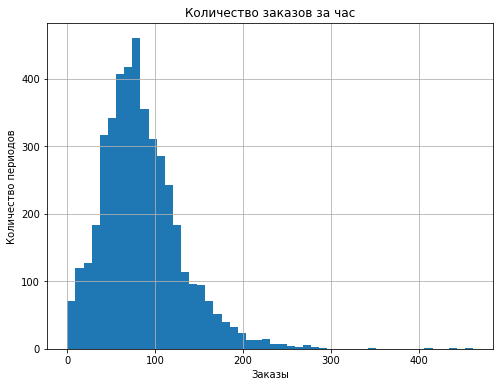

In [14]:
# гистограмма по количеству заказов
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
 
ax.hist(data_taxi['num_orders'], 50)
ax.grid()

plt.title('Количество заказов за час')
plt.xlabel('Заказы')
plt.ylabel('Количество периодов')
plt.show()

Распределение количества заказов нормальное.

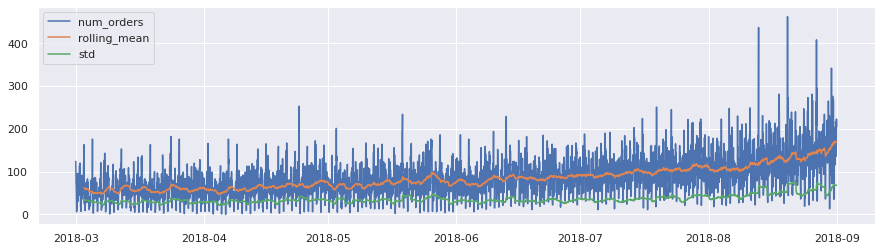

In [15]:
# размер графиков
sns.set(rc={'figure.figsize': (15, 4)})

# общий график для данных
plt.plot(data_taxi['num_orders'], label='num_orders')
plt.plot(data_taxi['num_orders'].rolling(50).mean(), label='rolling_mean')
plt.plot(data_taxi['num_orders'].rolling(50).std(), label='std')
plt.legend()
plt.show()

Рассмотрим данные на промежутках поменьше. Также стоит рассмотреть наличие трендов, сезонности.

In [16]:
# Декомпозируем данные
decomposed_taxi = seasonal_decompose(data_taxi)

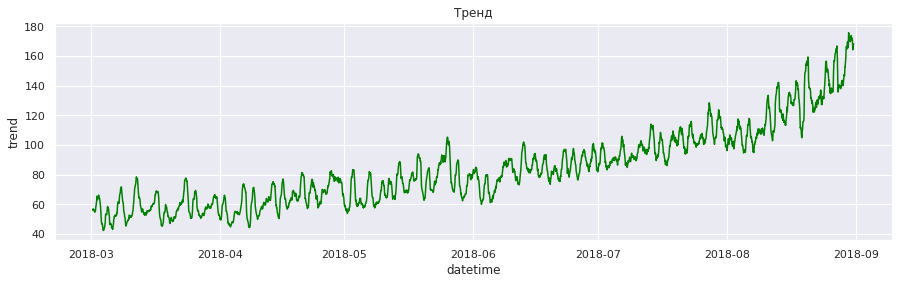

In [17]:
# График трендов
plotting(decomposed_taxi.trend, 'Тренд')

Очевиден тренд на повышение количества заказов к августу: летом чаще люди летают куда-либо, в связи с чем заказы в аэропорты растут.

In [18]:
# График сезонности
plotting(decomposed_taxi.seasonal, 'Сезонность')

In [19]:
# Рассмотрим график сезонности поближе
plotting(decomposed_taxi.seasonal['2018-03-01':'2018-03-07'], 'Сезонность (за одну неделю)')
plotting(decomposed_taxi.seasonal['2018-03-01':'2018-03-02'], 'Сезонность (по часам за двое суток)')

- Минимальное количество заказов в ~ 06:00;
- Максимальное количество заказов в ~ 00:00;
- В течение дня количество заказов примерно среднее, небольшое повышение к 16 часам.

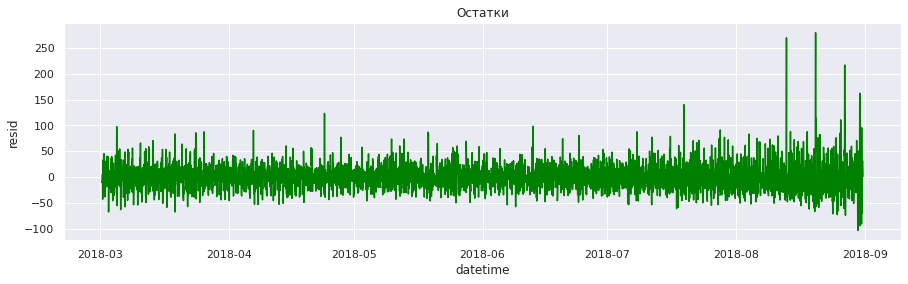

In [20]:
# График остатков (шумов)
plotting(decomposed_taxi.resid, 'Остатки')

По графику видно, что в августе появилось возрастание шумов, относительно представленного периода, что может дать в обученной модели относительно большую разницу в метриках при обучении и на тестовой выборке. <br>
Возможно это связано с сезонностью, но это возможно определить на данных за несколько лет.<br>
Рекомендуем компании «Чётенькое такси» собрать данные за более длительный период (минимум за 2 года).

Также рассмотрим недельную сезонность.

In [21]:
# Декомпозируем данные
decomposed_taxi_days = seasonal_decompose(data_taxi_days)

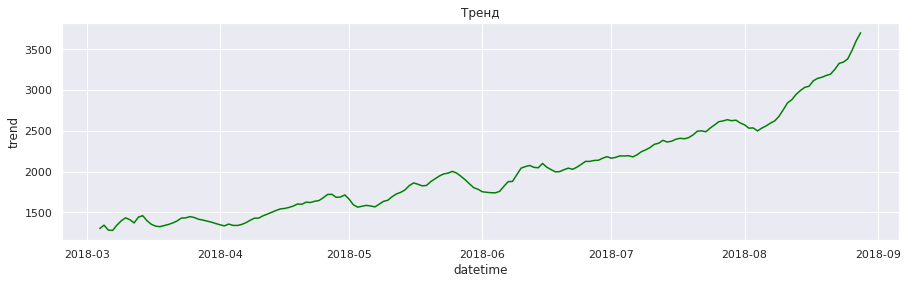

In [22]:
# График трендов
plotting(decomposed_taxi_days.trend, 'Тренд')

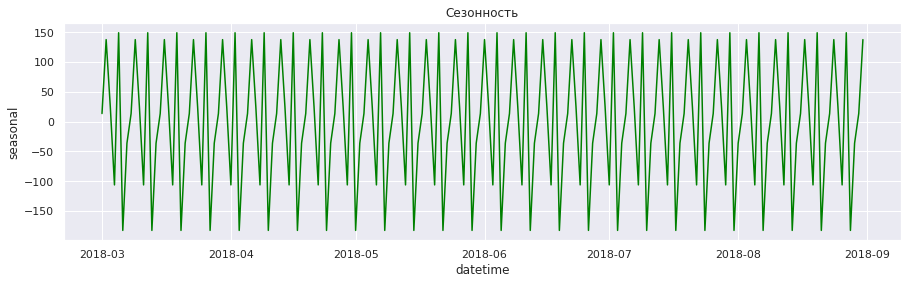

In [23]:
# График сезонности
plotting(decomposed_taxi_days.seasonal, 'Сезонность')

In [24]:
# Рассмотрим график сезонности поближе
plotting(decomposed_taxi_days.seasonal['2018-03-01':'2018-03-28'], 'Сезонность (за 4 недели)')
plotting(decomposed_taxi_days.seasonal['2018-03-01':'2018-05-23'], 'Сезонность (за 12 недель)')

- Минимальное количество заказов по вторникам;
- Максимальное количество заказов по понедельникам и пятницам;
- По графику за 12 недель видно, что сезонность по дням недели идентична графику за 4 недели.

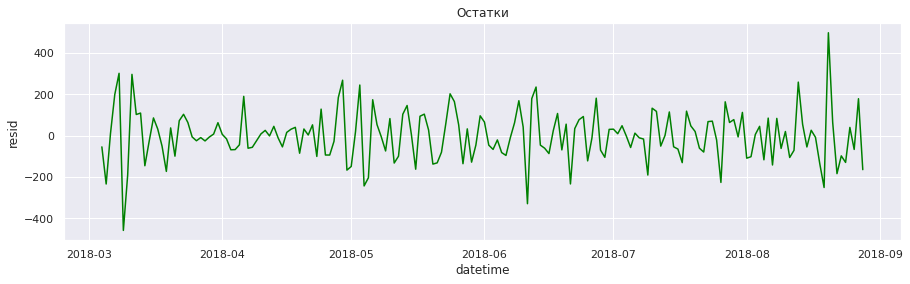

In [25]:
# График остатков (шумов)
plotting(decomposed_taxi_days.resid, 'Остатки')

## Обучение

In [26]:
# датасет для обучения моделей
data_ml = make_features(data_taxi, 168, 168)
display(f'Размер оригинального датасета: {data_taxi.shape}')
display(f'Размер обновленного датасета: {data_ml.shape}')

/tmp/ipykernel_327/2244010857.py:51: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_327/2244010857.py:51: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_327/2244010857.py:51: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_327/2244010857.py:51: PerformanceWarn

'Размер оригинального датасета: (4416, 1)'

'Размер обновленного датасета: (4248, 173)'

In [27]:
# разбиваем фичи и таргет
X = data_ml.drop('num_orders', axis=1)
y = data_ml['num_orders']

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=TEST_SIZE)

### LinearRegression

In [28]:
# Создадим пустой список для моделей c RMSE на кросс-валидации
models = []

In [29]:
start = time()

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

end = time()
linear_time = (end-start)/60

print('Время обучения модели: ', linear_time)

Время обучения модели:  0.009091238180796305


In [30]:
cv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(
    lin_reg,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

cv_score_lin_reg = (-1) * (sum(scores) / len(scores))
print('RMSE на кросс-валидации :', cv_score_lin_reg)

RMSE на кросс-валидации : 22.705331883471665


In [31]:
start = time()

y_pred_lin_reg = lin_reg.predict(X_train)

end = time()
linear_predict_time = (end-start)/60

print('Время предсказания модели:', linear_predict_time)

Время предсказания модели: 0.001827538013458252


In [32]:
models.append([lin_reg, cv_score_lin_reg])

### RandomForestRegressor

In [33]:
start = time()

rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

rf_params = {
    'n_estimators': range(50, 100, 10),
    'max_depth': range(5, 20, 5),
}

rf_grid = RandomizedSearchCV(
    rf_model,
    rf_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=10,
    cv=cv,
    verbose=5,
    random_state=RANDOM_STATE
)

rf_grid.fit(X_train, y_train)

end = time()
rf_time = (end-start)/60

print('Время обучения модели: ', rf_time)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...max_depth=10, n_estimators=90;, score=-20.254 total time=   3.0s
[CV 2/5] END ...max_depth=10, n_estimators=90;, score=-21.418 total time=   6.2s
[CV 3/5] END ...max_depth=10, n_estimators=90;, score=-21.847 total time=   9.5s
[CV 4/5] END ...max_depth=10, n_estimators=90;, score=-21.827 total time=  13.2s
[CV 5/5] END ...max_depth=10, n_estimators=90;, score=-30.274 total time=  16.5s
[CV 1/5] END ...max_depth=15, n_estimators=60;, score=-20.258 total time=   2.2s
[CV 2/5] END ...max_depth=15, n_estimators=60;, score=-21.610 total time=   5.2s
[CV 3/5] END ...max_depth=15, n_estimators=60;, score=-22.126 total time=   7.7s
[CV 4/5] END ...max_depth=15, n_estimators=60;, score=-21.661 total time=  10.7s
[CV 5/5] END ...max_depth=15, n_estimators=60;, score=-30.372 total time=  13.6s
[CV 1/5] END ....max_depth=5, n_estimators=50;, score=-20.535 total time=   1.0s
[CV 2/5] END ....max_depth=5, n_estimators=50;, 

In [34]:
rf = rf_grid.best_estimator_
rmse_cv_rf = (-1) * rf_grid.best_score_

print(f'Лучшая модель: \n {rf}')
print(f'RMSE RandomForestRegressor на кросс-валидации {rmse_cv_rf}')

Лучшая модель: 
 RandomForestRegressor(max_depth=10, n_estimators=90, random_state=42)
RMSE RandomForestRegressor на кросс-валидации 23.123918810680806


In [35]:
start = time()

y_pred_rf = rf.predict(X_train)

end = time()
rf_predict_time = (end-start)/60

print('Время предсказания модели:', rf_predict_time)

Время предсказания модели: 0.0011379480361938476


In [36]:
models.append([rf, rmse_cv_rf])

### CatBoostRegressor

In [37]:
start = time()

catboost_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
catboost_model.fit(X_train, y_train)

end = time()
cat_time = (end-start)/60

print('Время обучения модели: ', cat_time)

Время обучения модели:  0.6620454986890157


In [38]:
catboost_scores = cross_val_score(
    catboost_model,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

cv_score_catboost = sum(catboost_scores) / len(catboost_scores)
rmse_cv_catboost = (-1) * cv_score_catboost
print(f'RMSE на кросс-валидации :{rmse_cv_catboost}')

RMSE на кросс-валидации :22.69593810094007


In [39]:
start = time()

y_pred_catboost = catboost_model.predict(X_train)

end = time()
cat_predict_time = (end-start)/60

print('Время предсказания модели:', cat_predict_time)

Время предсказания модели: 0.00038090546925862633


In [40]:
models.append([catboost_model, rmse_cv_catboost])

### Анализ моделей

In [41]:
models_analysis = pd.DataFrame(models, columns=['model', 'RMSE_cv'])
models_analysis.sort_values('RMSE_cv')

model    RMSE_cv
2  <catboost.core.CatBoostRegressor object at 0x7...  22.695938
0                                 LinearRegression()  22.705332
1  (DecisionTreeRegressor(max_depth=10, max_featu...  23.123919

**RMSE на кросс-валидации:**
- LinearRegression == 22.705331883471665
- RandomForestRegressor == 23.123918810680806
- CatBoostRegressor == 22.69593810094007

На валидационной выборке лучшее значение - у CatBoostRegressor. Выбираем CatBoostRegressor.

## Тестирование

In [42]:
y_pred = catboost_model.predict(X_test)
best_rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE лучшей модели тестовой выборки:', best_rmse)

RMSE лучшей модели тестовой выборки: 37.28260555750387


In [43]:
# предсказания и истинные значения
def display_real_predict(target, pred, rmse):
    """    
    :param target: y_true, правильные ответы
    :param pred: y_pred, предсказанные ответы
    :param rmse: Лучшая полученная метрика качества
    :return: График
    """
    result = target.to_frame().reset_index()
    result['prediction'] = pd.Series(pred)
    result.set_index('datetime', inplace=True)

    plotting(result, 'RMSE=' + str(rmse))

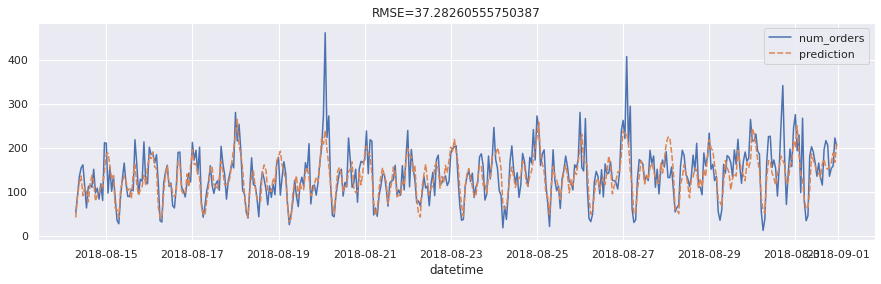

In [44]:
display_real_predict(y_test, y_pred, best_rmse)

Судя по графику визуализации предсказаний и фактических значений, можно сделать выводы:
- Модель ошибается на пиковых значениях, которые возможно связаны с аномально высоким спросом на такси. Данные пиковые значения к сезонности не привязаны;
- В большинстве случаев модель себя хорошо показывает. Значения предсказанйи практически совпадают с фактическим спросом.

## Общий вывод

В ходе работы над исследованием была построена модель машинного обучения, прогнозирующая количество заказов такси в следующий час. Финальное качество модели на тестовой выборке: RMSE == 37.28260555750387<br>

Исследование было разделено на несколько этапов:

1. **Загрузка и подготовка данных**


В таблице представленны данные о заказах такси в районе аэропорта.

Записей о заказах в таблице 26 496, они представляют из себя:<br>
Данные представлены за промежуток с 1 марта 2018 года по 31 августа 2018 года.<br>
Пропуски не обнаружены.<br>
Типы данных соответствуют требуемым.<br>
Ресемплировали данные по часам.

2. **Исследовательский анализ данных**

Построили несколько графиков для визуализации данных.<br>
Очевиден тренд на повышение количества заказов к августу: летом чаще люди летают куда-либо, в связи с чем заказы в аэропорты растут.<br>
Минимальное количество заказов в ~ 06:00.<br>
Максимальное количество заказов в ~ 00:00.<br>
В течение дня количество заказов примерно среднее, небольшое повышение к 16 часам.

3. **Обучение моделей**

Разбили данные на тренировочную и тестовую выборку. Тестовая выборка размером 10% от исходных данных.<br>
Перебрали 3 модели: LinearRegression, RandomForestRegressor и CatBoostRegressor.<br>
Все модели показали близкий результат метрики RMSE на кросс-валидации, однако в качестве лучшей выбрана CatBoostRegressor. Она показала лучший RMSE на кросс-валидации = 22.69593810094007 и быстрее остальных моделей предсказывает значения.

4. **Тестирование лучшей модели**

RMSE на тестовой метрике составило 37.28260555750387, что соответствует критерию от заказчика. Показатель RMSE на тестовой выборке должен быть не более 48.<br>
Визуализировали реальные значения и предсказанные лучшей моделью.